<div style="text-align:center;">
  <span style="color:#962323; font-size:45px; font-weight:bold; font-family:Arial;">Insurance</span>
</div>

### <span style="color:#FF9ADC; font-style:bold; font-family:Arial;">General import</span>

In [4]:
ON_KAGGLE = False

In [29]:
if ON_KAGGLE:
    !pip install seaborn --upgrade --quiet
else:
    import sys
    sys.path.append('..')
    %load_ext autoreload
    %autoreload 2

import os
import plotter
import utilities

import pandas as pd
import xgboost as xgb
import matplotlib.pyplot as plt

from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm

train_path = 'train.csv' if not ON_KAGGLE else ''
test_path  = 'test.csv' if not ON_KAGGLE else ''

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### <span style="color:#FF9ADC; font-style:bold; font-family:Arial;">Loading Data</span>

##### <span style="color:#FFC59A; font-family:Arial;">Read data and drop ID column</span>

In [31]:
df_train = pd.read_csv(train_path)
df_test  = pd.read_csv(test_path)

id_test = df_test['id']

df_train.drop(columns=['id'], inplace=True)
df_test.drop(columns=['id'], inplace=True)

assert not df_train.empty
assert not df_test.empty
assert df_train.columns[:-1].equals(df_test.columns)

##### <span style="color:#FFC59A; font-family:Arial;">Visualize head dataframes</span>

In [7]:
print('_________________________________________________________________Train_________________________________________________________________')
df_train.head(3)

_________________________________________________________________Train_________________________________________________________________


,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,Male,21,1,35.0,0,1-2 Year,Yes,65101.0,124.0,187,0
1,Male,43,1,28.0,0,> 2 Years,Yes,58911.0,26.0,288,1
2,Female,25,1,14.0,1,< 1 Year,No,38043.0,152.0,254,0


In [8]:
print('_________________________________________________________________Test_________________________________________________________________')
df_test.head(3)

_________________________________________________________________Test_________________________________________________________________


,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage
0,Female,20,1,47.0,0,< 1 Year,No,2630.0,160.0,228
1,Male,47,1,28.0,0,1-2 Year,Yes,37483.0,124.0,123
2,Male,47,1,43.0,0,1-2 Year,Yes,2630.0,26.0,271


##### <span style="color:#FFC59A; font-family:Arial;">Columns description and type</span>

**Age**:                  Age of the Customer.      

**Gender**:               Gender of the Customer. 

**Driving_License**:      0 for customer not having DL, 1 for customer having DL.   

**Region_Code**:          Unique code for the region of the customer.  

**Previously_Insured**:   0 for customer not having vehicle insurance, 1 for customer having vehicle insurance. 

**Vehicle_Age**:          Age of the vehicle.  

**Vehicle_Damage**:       Customer got his/her vehicle damaged in the past. 0: Customer didn't get his/her vehicle damaged in the past. 

**Annual_Premium**:       The amount customer needs to pay as premium in the year.   

**Policy_Sales_Channel**: Anonymized Code for the channel of outreaching to the customer ie. Different Agents, Over Mail, Over Phone, In Person, etc. 

**Vintage**:              Number of Days, Customer has been associated with the company.   

**Response**:             1 for Customer is interested, 0 for Customer is not interested.                                      

In [9]:
# We check the data types of the columns
pd.DataFrame(df_train.dtypes, columns=['Data Type']).T

,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
Data Type,object,int64,int64,float64,int64,object,object,float64,float64,int64,int64


##### <span style="color:#FFC59A; font-family:Arial;">Distinct values and their occurence</span>

In [10]:
distinct_values_train = utilities.get_distinct_value(df_train)
distinct_values_test  = utilities.get_distinct_value(df_test)

distinct_values_train = {k: utilities.keep_top(v, 5) for k, v in distinct_values_train.items()}
distinct_values_test  = {k: utilities.keep_top(v, 5) for k, v in distinct_values_test.items()}

In [11]:
distinct_values_train

{'Gender': {'Male': 6228134, 'Female': 5276664},
 'Age': {24: 815884, 23: 750298, 22: 661236, 25: 635677, 21: 503310},
 'Driving_License': {1: 11482041, 0: 22757},
 'Region_Code': {28.0: 3451062,
  8.0: 1021036,
  46.0: 578208,
  41.0: 557581,
  15.0: 403977},
 'Previously_Insured': {0: 6178116, 1: 5326682},
 'Vehicle_Age': {'1-2 Year': 5982678,
  '< 1 Year': 5044145,
  '> 2 Years': 477975},
 'Vehicle_Damage': {'Yes': 5783229, 'No': 5721569},
 'Annual_Premium': {2630.0: 2112561,
  38287.0: 6363,
  39008.0: 5285,
  38452.0: 4721,
  28861.0: 4671},
 'Policy_Sales_Channel': {152.0: 4166183,
  26.0: 2433456,
  124.0: 2264490,
  160.0: 640380,
  156.0: 316693},
 'Vintage': {187: 98018, 282: 96377, 131: 91892, 256: 90945, 232: 85183},
 'Response': {0: 10089739, 1: 1415059}}

### <span style="color:#FF9ADC; font-style:bold; font-family:Arial;">EDA</span>

##### <span style="color:#FFC59A; font-family:Arial;">Encoding of non float data</span>

In [12]:
df_train['Gender'] = df_train['Gender'].replace({'Male': 1.0, 'Female': 0.0})
df_test['Gender']  = df_test['Gender'].replace({'Male': 1.0, 'Female': 0.0})

df_train['Vehicle_Damage'] = df_train['Vehicle_Damage'].replace({'Yes': 1.0, 'No': 0.0})
df_test['Vehicle_Damage']  = df_test['Vehicle_Damage'].replace({'Yes': 1.0, 'No': 0.0})

# Use label encoding for Vehicle_Age
df_train['Vehicle_Age'] = df_train['Vehicle_Age'].replace({'< 1 Year': 0, '1-2 Year': 1, '> 2 Years': 2})
df_test['Vehicle_Age']  = df_test['Vehicle_Age'].replace({'< 1 Year': 0, '1-2 Year': 1, '> 2 Years': 2})

df_train['Gender'] = df_train['Gender'].astype(float)
df_test['Gender']  = df_test['Gender'].astype(float)

df_train['Vehicle_Damage'] = df_train['Vehicle_Damage'].astype(float)
df_test['Vehicle_Damage']  = df_test['Vehicle_Damage'].astype(float)

df_train['Vehicle_Age'] = df_train['Vehicle_Age'].astype(int)
df_test['Vehicle_Age']  = df_test['Vehicle_Age'].astype(int)

/tmp/ipykernel_1915/42932580.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_train['Gender'] = df_train['Gender'].replace({'Male': 1.0, 'Female': 0.0})
/tmp/ipykernel_1915/42932580.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_test['Gender']  = df_test['Gender'].replace({'Male': 1.0, 'Female': 0.0})
/tmp/ipykernel_1915/42932580.py:4: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. 

##### <span style="color:#FFC59A; font-family:Arial;">Base stats on dataframes</span>

In [13]:
df_train.describe()

,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
count,1.150480e+07,1.150480e+07,1.150480e+07,1.150480e+07,1.150480e+07,1.150480e+07,1.150480e+07,1.150480e+07,1.150480e+07,1.150480e+07,1.150480e+07
mean,5.413510e-01,3.838356e+01,9.980220e-01,2.641869e+01,4.629966e-01,6.031073e-01,5.026798e-01,3.046137e+04,1.124254e+02,1.638977e+02,1.229973e-01
std,4.982872e-01,1.499346e+01,4.443120e-02,1.299159e+01,4.986289e-01,5.678559e-01,4.999928e-01,1.645475e+04,5.403571e+01,7.997953e+01,3.284341e-01
min,0.000000e+00,2.000000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.630000e+03,1.000000e+00,1.000000e+01,0.000000e+00
25%,0.000000e+00,2.400000e+01,1.000000e+00,1.500000e+01,0.000000e+00,0.000000e+00,0.000000e+00,2.527700e+04,2.900000e+01,9.900000e+01,0.000000e+00
50%,1.000000e+00,3.600000e+01,1.000000e+00,2.800000e+01,0.000000e+00,1.000000e+00,1.000000e+00,3.182400e+04,1.510000e+02,1.660000e+02,0.000000e+00
75%,1.000000e+00,4.900000e+01,1.000000e+00,3.500000e+01,1.000000e+00,1.000000e+00,1.000000e+00,3.945100e+04,1.520000e+02,2.320000e+02,0.000000e+00
max,1.000000e+00,8.500000e+01,1.000000e+00,5.200000e+01,1.000000e+00,2.000000e+00,1.000000e+00,5.401650e+05,1.630000e+02,2.990000e+02,1.000000e+00


In [14]:
df_test.describe()

,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage
count,7.669866e+06,7.669866e+06,7.669866e+06,7.669866e+06,7.669866e+06,7.669866e+06,7.669866e+06,7.669866e+06,7.669866e+06,7.669866e+06
mean,5.412613e-01,3.839137e+01,9.980208e-01,2.642661e+01,4.630772e-01,6.033933e-01,5.025463e-01,3.046553e+04,1.123650e+02,1.638996e+02
std,4.982946e-01,1.499951e+01,4.444387e-02,1.299433e+01,4.986349e-01,5.679612e-01,4.999935e-01,1.644586e+04,5.407358e+01,7.998445e+01
min,0.000000e+00,2.000000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.630000e+03,1.000000e+00,1.000000e+01
25%,0.000000e+00,2.400000e+01,1.000000e+00,1.500000e+01,0.000000e+00,0.000000e+00,0.000000e+00,2.528000e+04,2.900000e+01,9.900000e+01
50%,1.000000e+00,3.600000e+01,1.000000e+00,2.800000e+01,0.000000e+00,1.000000e+00,1.000000e+00,3.182700e+04,1.510000e+02,1.660000e+02
75%,1.000000e+00,4.900000e+01,1.000000e+00,3.500000e+01,1.000000e+00,1.000000e+00,1.000000e+00,3.946000e+04,1.520000e+02,2.320000e+02
max,1.000000e+00,8.500000e+01,1.000000e+00,5.200000e+01,1.000000e+00,2.000000e+00,1.000000e+00,5.401650e+05,1.630000e+02,2.990000e+02


##### <span style="color:#FFC59A; font-family:Arial;">Missing values</span>

In [15]:
nan_train = pd.DataFrame(df_train.isnull().sum()).T
nan_train.index = ['Train']
nan_test  = pd.DataFrame(df_test.isnull().sum()).T
nan_test.index = ['Test']
pd.concat([nan_train, nan_test], axis=0)

,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
Train,0,0,0,0,0,0,0,0,0,0,0.0
Test,0,0,0,0,0,0,0,0,0,0,NaN


##### <span style="color:#FFC59A; font-family:Arial;">Duplicates</span>

In [16]:
duplicates_train = df_train.duplicated().sum()
duplicates_test  = df_test.duplicated().sum()

print(f'There are {duplicates_train} duplicate{s if duplicates_train > 1 else ""} in the train set')
print(f'There are {duplicates_test} duplicate{s if duplicates_test > 1 else ""} in the test set')

There are 0 duplicate in the train set
There are 0 duplicate in the test set


##### <span style="color:#FFC59A; font-family:Arial;">Target distribution (histogram and pie)</span>

,Labels,Counts,Percentages
0,0,10089739,87.700271
1,1,1415059,12.299729


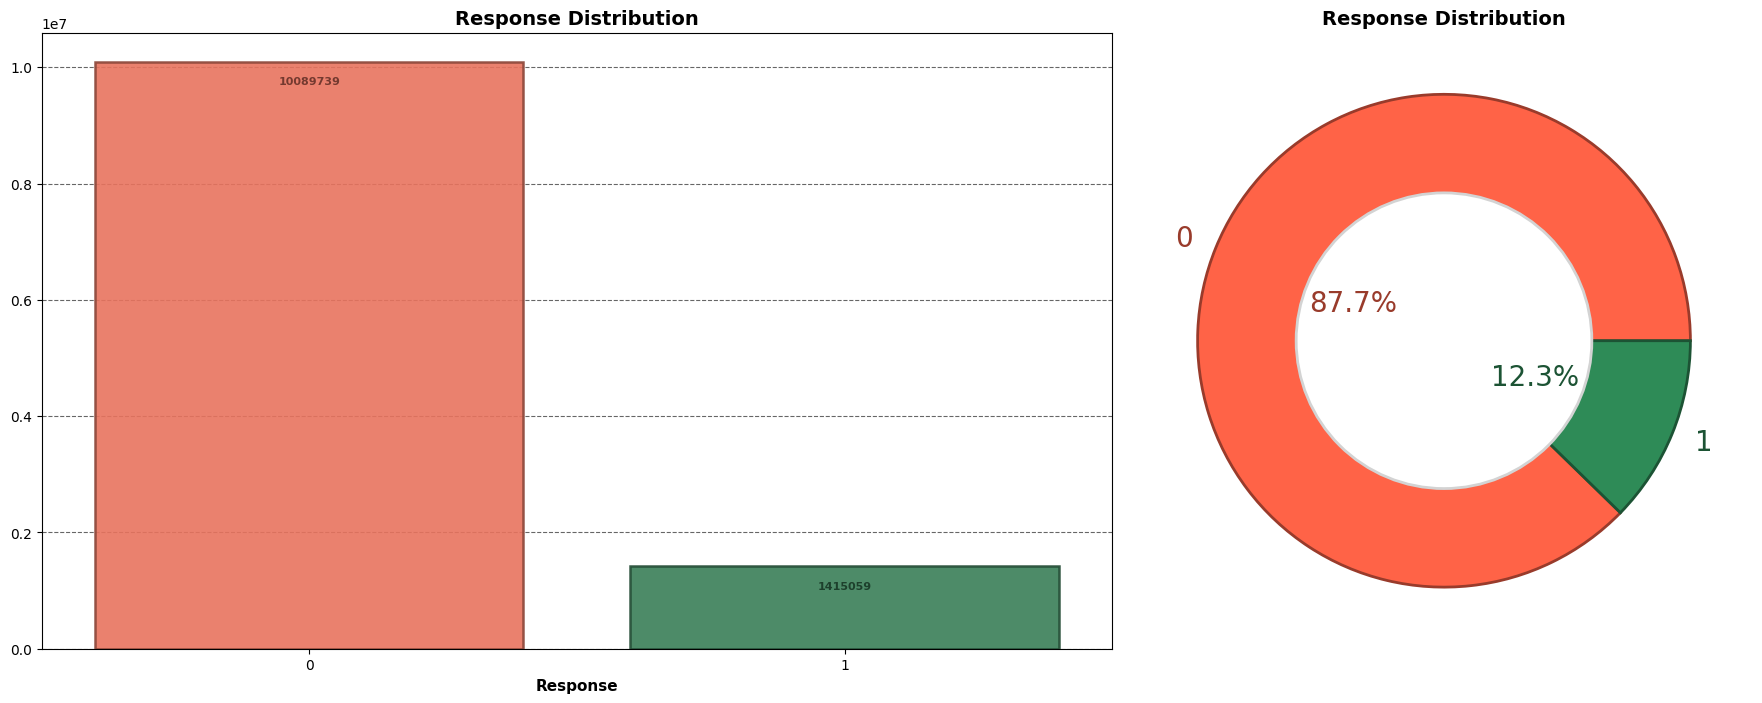

In [17]:
plt.figure(figsize=(25, 8))
plt.subplots_adjust(wspace=-0.19, hspace=0.1)
ax = plt.subplot(121)
plotter.plot_hist_discrete_feature(ax, df_train, 'Response', 
                                     color=['tomato', 'seagreen'],
                                     title='Response Distribution')

ax = plt.subplot(122)
plotter.plot_pie_feature(ax, df_train, 'Response', color=['tomato', 'seagreen'], 
                           annot_fontsize=20, donnut_style=True, linewidth=2,
                           donnut_size=0.6, annot_distance=0.4,
                           title='Response Distribution')

The Target column seems to have a huge `class imbalance`. We'll certainly need to address this later on with the [`SMOTE`](https://imbalanced-learn.org/stable/references/generated/imblearn.over_sampling.SMOTE.html) (*S*ynthetic *M*inority *O*versampling *TE*chnique) strategy (oversampling) or an undersampling strategy.

##### <span style="color:#FFC59A; font-family:Arial;">Feature distribution</span>

In [18]:
# For all the numerical features we plot the KDE
numerical_features   = ['Age', 'Region_Code', 'Annual_Premium', 'Policy_Sales_Channel', 'Vintage']

# For all the categorical features we plot the pie chart
categorical_features = ['Gender', 'Driving_License', 'Previously_Insured', 'Vehicle_Age', 'Vehicle_Damage']

image_path_num = 'numerical_features.png' if not ON_KAGGLE else '/kaggle/working/numerical_features.png'
image_path_cat = 'categorical_features.png' if not ON_KAGGLE else '/kaggle/working/categorical_features.png'

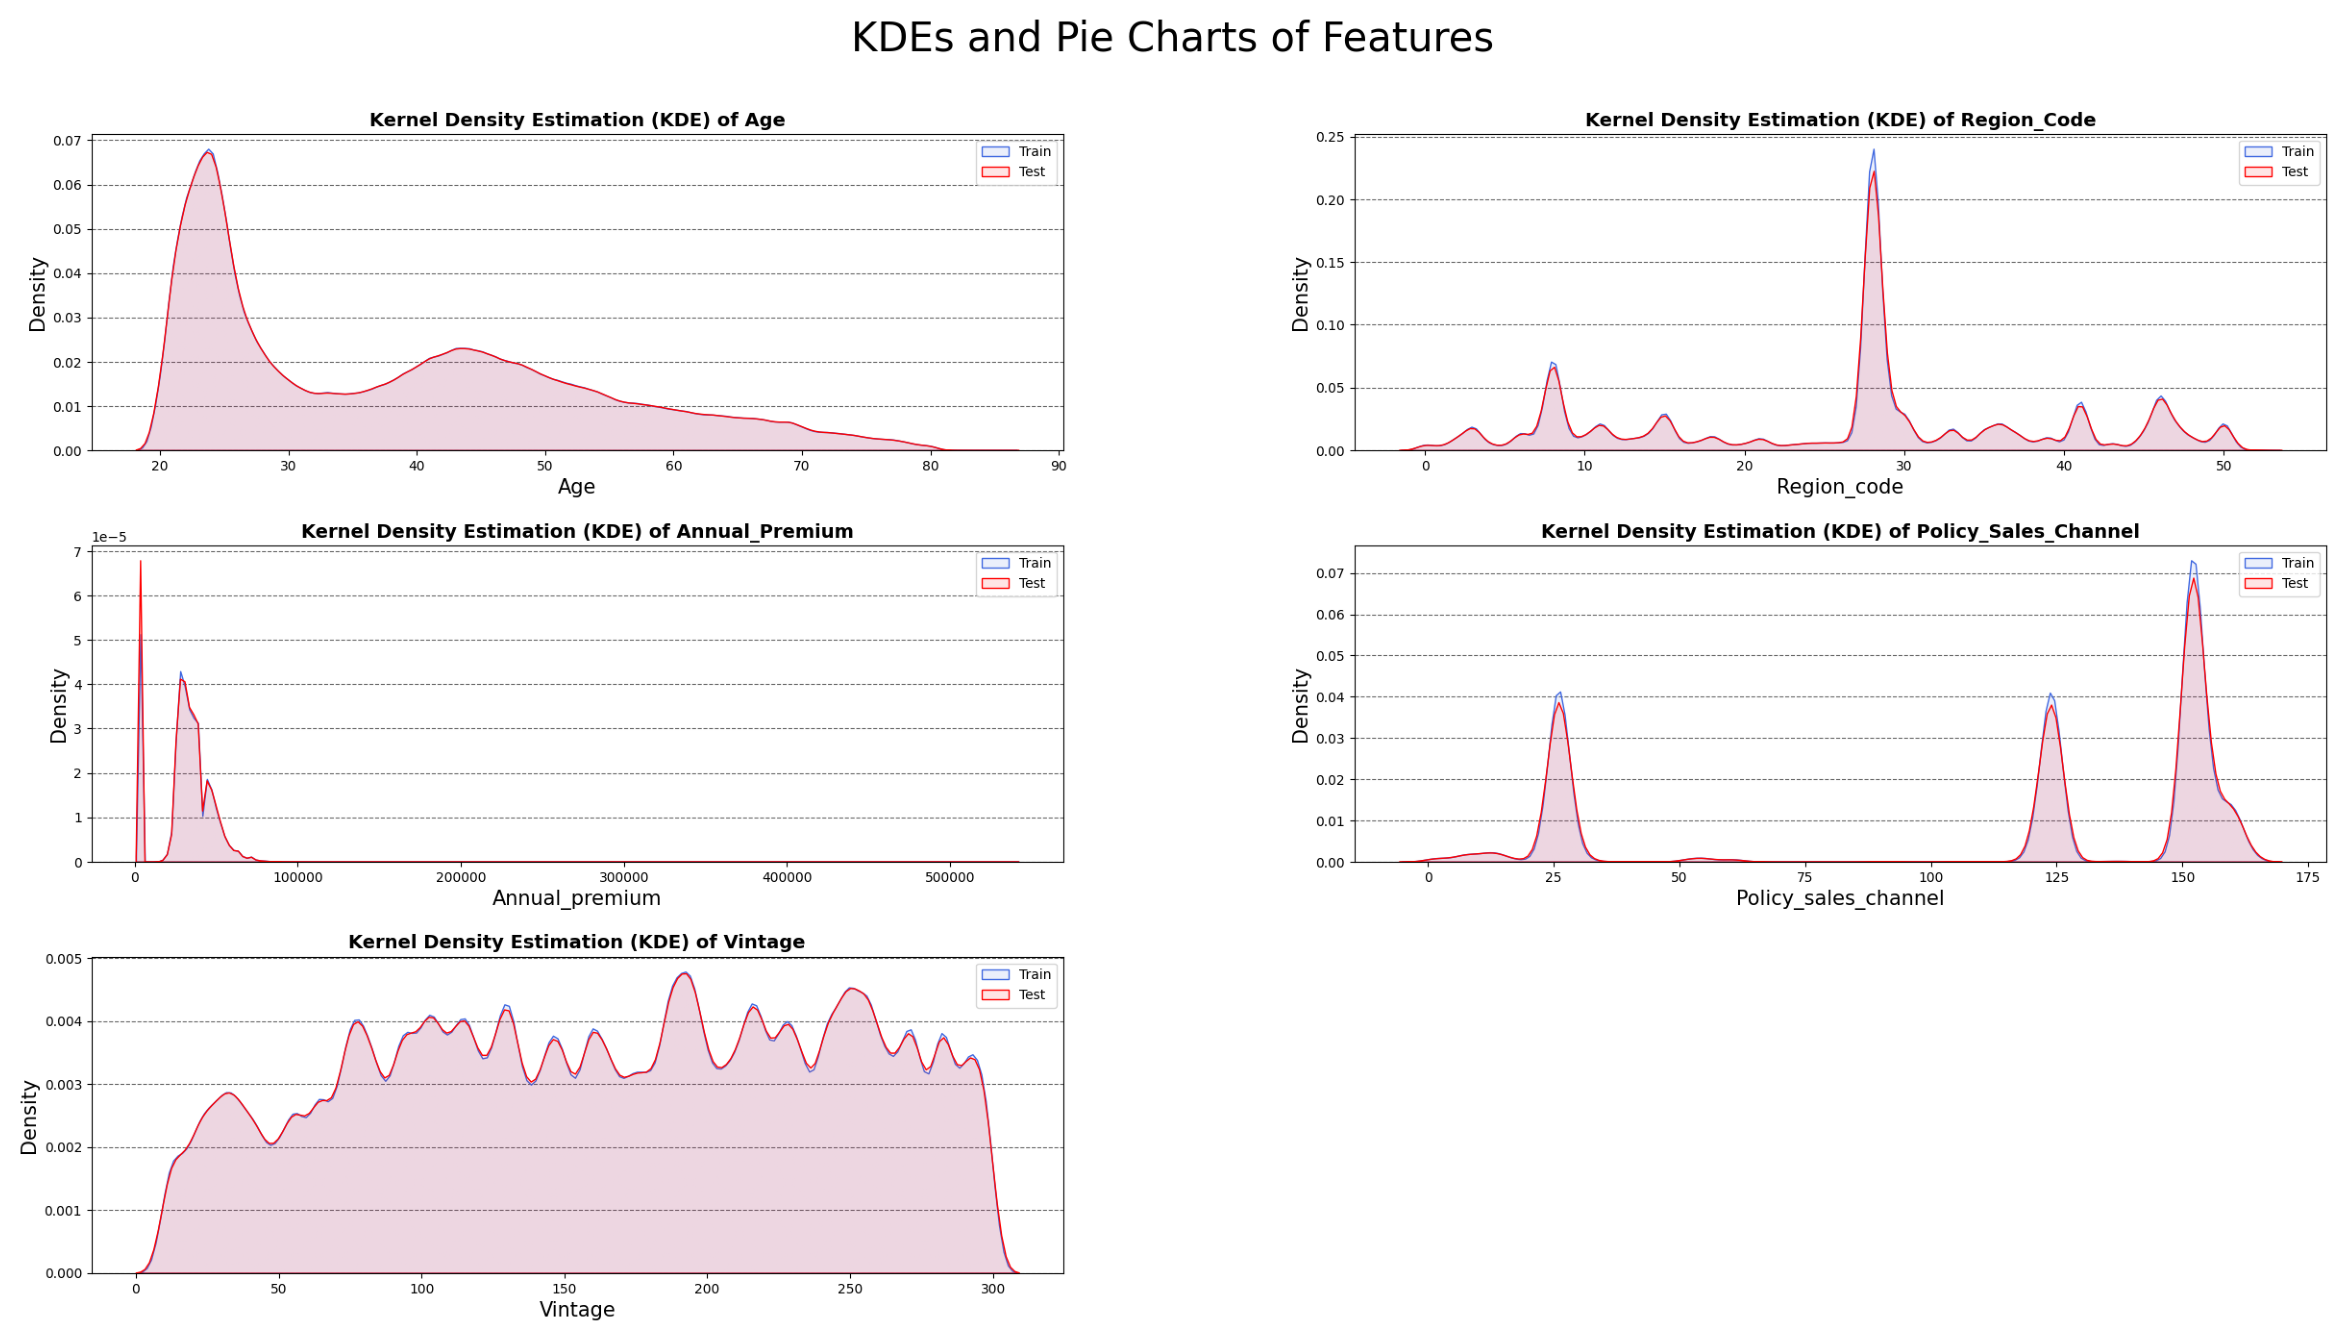

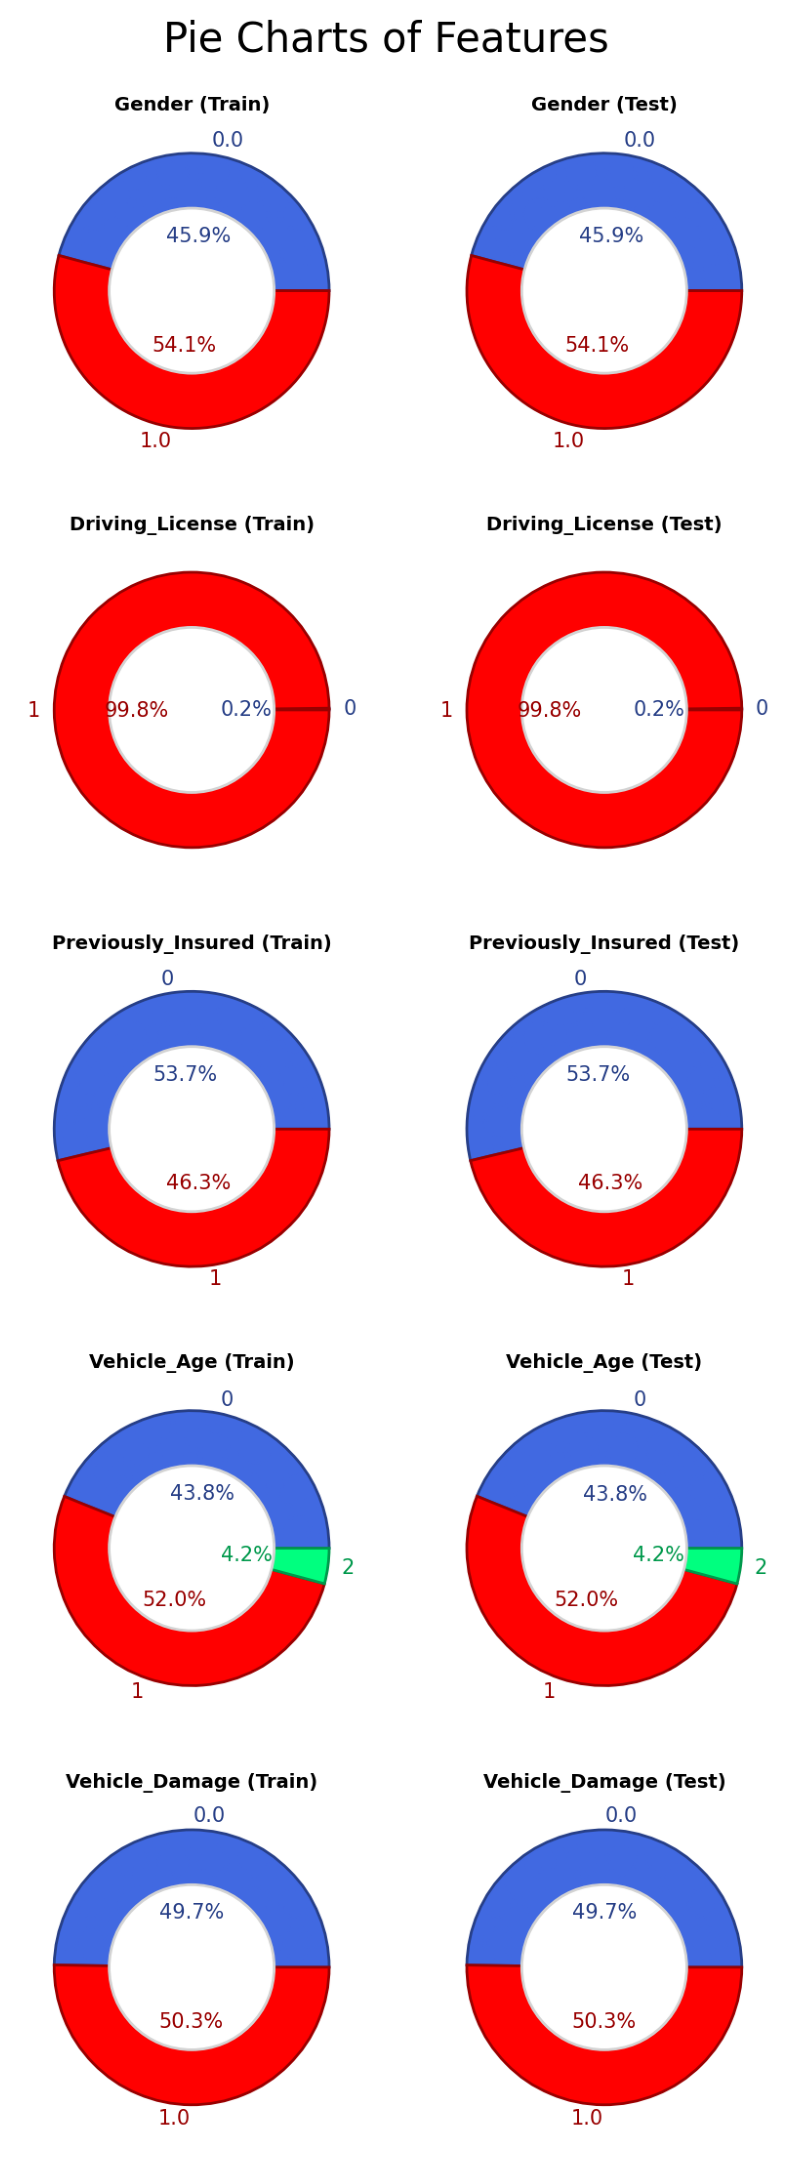

In [19]:
if os.path.exists(image_path_num) and os.path.exists(image_path_cat):
    plt.figure(figsize=(30, 50))
    img = plt.imread(image_path_num)
    plt.imshow(img)
    plt.axis('off')
    plt.show()

    plt.figure(figsize=(10, 50))
    img = plt.imread(image_path_cat)
    plt.imshow(img)
    plt.axis('off') 
    plt.show()

else:
    num_rows = int(len(numerical_features) / 2) + 1
    total_columns = 2

    plt.figure(figsize=(30, num_rows * 5))
    plt.suptitle('KDEs and Pie Charts of Features', fontsize=30)
    plt.subplots_adjust(top=0.90, wspace=0.3, hspace=0.3)

    for i, feature in enumerate(tqdm(numerical_features, desc="Plotting KDEs")):
        ax = plt.subplot(num_rows, total_columns, i+1)
        plotter.plot_kde(ax, [df_train, df_test], column=feature, 
                        color=['royalblue', 'red'], labels=['Train', 'Test'], 
                        fill=True, alpha=0.1, x_label_fontsize=15, y_label_fontsize=15,
                        x_label_bold=False, y_label_bold=False)

    plt.savefig(image_path_num, bbox_inches='tight')
    plt.show()

    ### ------------------------------------------------------------------------------------------------------------------------------------------------- ###

    num_rows = int(len(categorical_features) / 2) + 3
    total_columns = 2

    plt.figure(figsize=(10, num_rows * 5))
    plt.suptitle('Pie Charts of Features', fontsize=30, ha='center')
    plt.subplots_adjust(top=0.94, wspace=0.2, hspace=0.2)
    for i, feature in enumerate(tqdm(categorical_features, desc="Plotting Pie Charts")):
        for j, df in enumerate([df_train, df_test]):
            ax = plt.subplot(num_rows, total_columns, (i * 2) + j + 1)
            color = ['royalblue', 'red'] if feature != 'Vehicle_Age' else ['royalblue', 'red', 'springgreen']
            title_suffix = 'Train' if j == 0 else 'Test'
            plotter.plot_pie_feature(ax, df, feature, color=color, 
                                       annot_fontsize=15, donnut_style=True, linewidth=2,
                                       donnut_size=0.6, annot_distance=0.4, title=f'{feature} ({title_suffix})')

    plt.savefig(image_path_cat, bbox_inches='tight')
    plt.show()

The distribution of the features between train and test datasets is very similar. This is a good sign that they were split correctly and that the model will be able to generalize well.

##### <span style="color:#FFC59A; font-family:Arial;">Correlation Matrix</span>

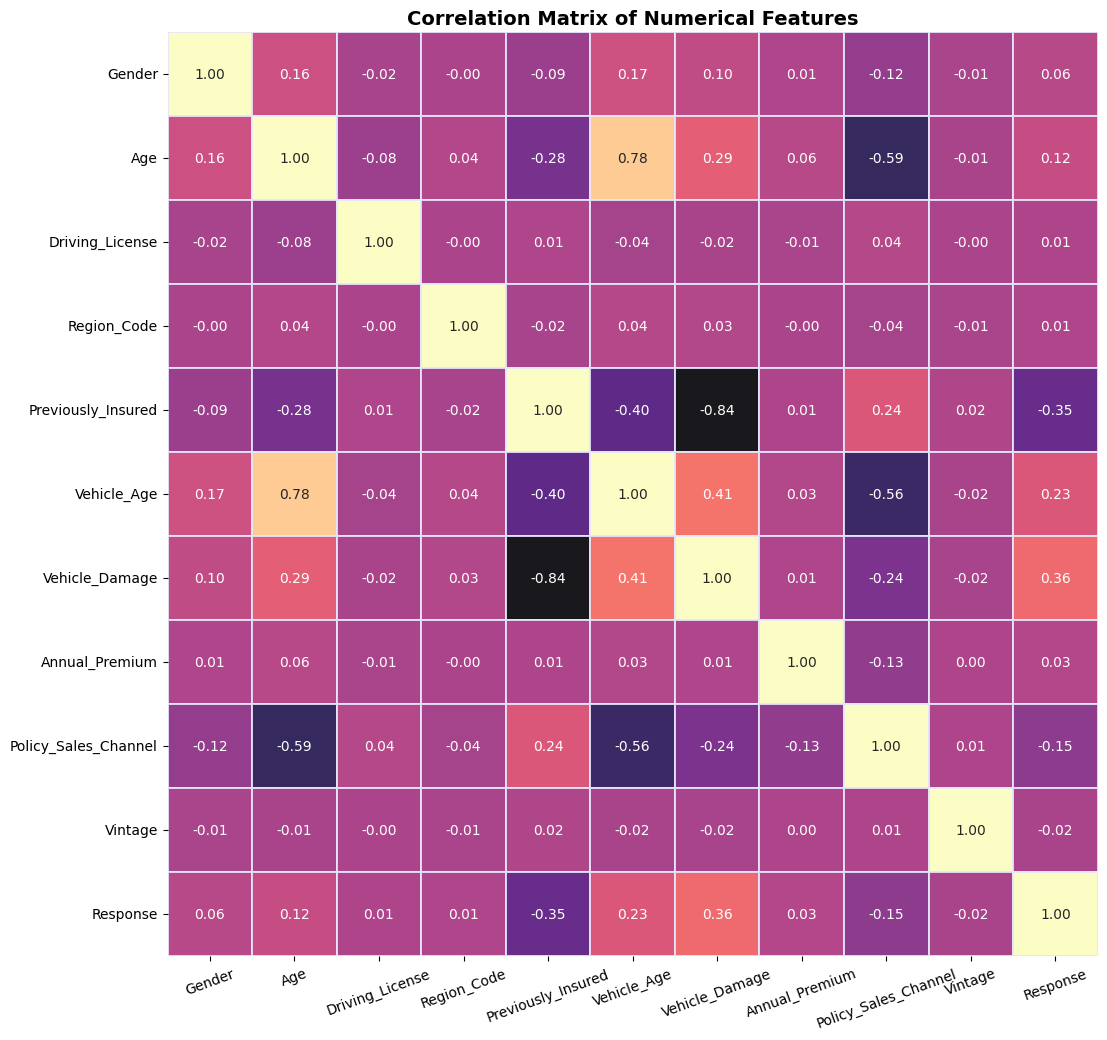

In [20]:
# Plotting the correlation matrix
plt.figure(figsize=(12, 12))
plt.title('Correlation Matrix', fontsize=20)
corr_matrix_test = plotter.plot_correlation_matrix_heatmap(ax, df_train, cmap='magma',
                                                           title='Correlation Matrix of Numerical Features',
                                                           linewidths=0.1, linecolor='lavender', rotation=20)

1. **Feature Engineering**:
   - Given the strong negative correlation between (`Age` and `Policy_Sales_Channel`) and (`Vehicle_Damage` and `Previously_Insured`), it may be beneficial to create new features or interaction terms to capture this relationship more effectively in predictive models.
   
2. **Data Transformation**:
   - For features with very weak correlations, we can consider using them in conjunction with other features or through non-linear transformations if they are important for model performance.

3. **Model Selection**:
   - Since most features have weak correlations, linear models might not capture complex relationships well. Consider using more sophisticated models like decision trees, random forests, or gradient boosting machines that can handle non-linear relationships.



### <span style="color:#FF9ADC; font-style:bold; font-family:Arial;">Training and prediction</span>

##### <span style="color:#FFC59A; font-family:Arial;">Hyperparameters</span>

In [ ]:
xgb_params = {
    'eval_metric': 'auc',
    'n_estimators': 3000,
    'eta': 0.05,
    'alpha':  0.2545607592482198,
    'subsample': 0.8388163485383147, 
    'colsample_bytree': 0.2732499701466825, 
    'max_depth': 16,
    'min_child_weight': 5,
    'gamma': 0.0017688666476104672,
    'max_bin': 262143,  
    'tree_method': 'hist',
    'device': 'cuda',
    'enable_categorical': True,
    'early_stopping_rounds': 50,
}

cat_params = {
    'loss_function': 'Logloss',
    'eval_metric': 'AUC',
    'class_names': [0, 1],
    'learning_rate': 0.075,
    'iterations': 3000,
    'depth': 9,
    'random_strength': 0,
    'l2_leaf_reg': 0.5,
    'max_leaves': 512,
    'fold_permutation_block': 64,
    'task_type': 'GPU',
    'random_seed': 42,
    'verbose': False,
    'allow_writing_files': False
}

##### <span style="color:#FFC59A; font-family:Arial;">Splitting and scaling</span>

In [30]:
X = df_train.drop(columns=['Response'])
y = df_train['Response']

X_test = df_test

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

##### <span style="color:#FFC59A; font-family:Arial;">Training XGB</span>

In [ ]:
dtrain = xgb.DMatrix(X_train, label=y_train)
dval = xgb.DMatrix(X_val, label=y_val)

model = xgb.train(xgb_params, dtrain, evals=[(dval, 'eval')], verbose_eval=100)

y_pred_xgb = model.predict(dval)
roc_auc_xgb = roc_auc_score(y_val, y_pred)

print(f'ROC AUC Score for XGBoost: {roc_auc_xgb}')

##### <span style="color:#FFC59A; font-family:Arial;">Training Catboost</span>

In [ ]:
cat_model = CatBoostClassifier(**cat_params)
cat_model   = cat_model.fit(X_train, y_train, eval_set=(X_val, y_val), verbose=100)

y_pred_cat = cat_model.predict_proba(X_val)[:, 1]
roc_auc_cat = roc_auc_score(y_val, y_pred_cat)

print(f'ROC AUC Score for CatBoost: {roc_auc_cat}')

##### <span style="color:#FFC59A; font-family:Arial;">Test Prediction
</span>

In [ ]:
# Predicting the test set
dtest = xgb.DMatrix(X_test)
y_pred_test_xgb = model.predict(dtest)

y_pred_test_cat = cat_model.predict_proba(X_test)[:, 1]

# Mean of the predictions with more weight on the CatBoost model
y_pred = (y_pred_test_xgb + y_pred_test_cat * 2) / 3

##### <span style="color:#FFC59A; font-family:Arial;">Submission</span>

In [ ]:
# Create the submission file
submission = pd.DataFrame({'id': id_test, 'Response': y_pred})

submission.to_csv('submission.csv', index=False)